In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml2020spring-hw3/food-11/validation/8_248.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/5_365.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/8_210.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/5_0.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/9_104.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/0_307.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/3_200.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/5_59.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/2_245.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/9_276.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/8_209.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/2_178.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/9_85.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/9_161.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/4_316.jpg
/kaggle/input/ml2020spring-hw3/food-11/validation/0_249.jpg
/kaggle/input/ml2020spring-hw3/food-11/valid

In [34]:
# Import需要的套件
import os
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import time

# 讀取圖片
利用 OpenCV (cv2) 讀入照片並存放在 numpy array 中

In [35]:
def readfile(path, label):
    # 輸入參數label為boolean變量，代表是否返回 y 值
    image_dir = sorted(os.listdir(path))  # os.listdir返回文件夾包含的文件名字的列表
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)  # shape:文件個數*128*128*3
    y = np.zeros((len(image_dir)), dtype=np.uint8)  # 形狀:文件個數
    for i, file in enumerate(image_dir):  # 遍歷文件列表中文件名
        img = cv2.imread(os.path.join(path, file))  # cv2讀入原圖片
        x[i, :, :] = cv2.resize(img, (128, 128))  # 對圖片進行縮放，存儲到x的第i個元素中
        if label:
            y[i] = int(file.split("_")[0])  # 取出文件名中的類別訊息

    if label:
      return x, y
    else:
      return x

In [36]:
workspace_dir = '/kaggle/input/ml2020spring-hw3/food-11/'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。



In [38]:
# data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
#     transforms.RandomRotation(15), # 隨機選擇圖片
    transforms.ToTensor(), # 將圖片轉為Tensor，並把數值 normalize 到 [0,1] (data normalization)
])

# 測試數據不須增強
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])

class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        # label type: LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    # 返回dataset的大小
    def __len__(self):
        return len(self.x)
    # 用[ ]取值時，dataset如何返回
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [39]:
batch_size = 128
train_set = ImgDataset(train_x, train_y, train_transform)
val_set = ImgDataset(val_x, val_y, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [40]:
print(len(train_set))

9866


# Model

In [41]:
# # baseline-cell

# class Classifier(nn.Module):
#     def __init__(self):
#         super(Classifier, self).__init__()
#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
#         # torch.nn.MaxPool2d(kernel_size, stride, padding)
#         # input 維度 [3, 128, 128]
#         self.cnn = nn.Sequential(
#             nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]


#             nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

#             nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

#             nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
#             nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
#         )
#         # fully connected
#         self.fc = nn.Sequential(
#             nn.Linear(512*4*4, 1024),#nn.Linear(in_features , out_features)
#             nn.ReLU(),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Linear(512, 11)
#         )

#     def forward(self, x):
#         out = self.cnn(x)
#         out = out.view(out.size()[0], -1)
#         return self.fc(out)
# def params_count(model):
#     """
#     Compute the number of parameters.
#     Args:
#         model (model): model to count the number of parameters.
#     """
#     return np.sum([p.numel() for p in model.parameters()]).item()

In [42]:
# half_CNN

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),  # [128, 128, 128]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 64, 64]


            nn.Conv2d(128, 256, 3, 1, 1), # [256, 64, 64]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),       # [512, 4, 4]
            
        )
        # fullly connected
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),#nn.Linear(in_features , out_features)
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
def params_count(model):
    """
    Compute the number of parameters.
    Args:
        model (model): model to count the number of parameters.
    """
    return np.sum([p.numel() for p in model.parameters()]).item()

# Training
使用 training set 訓練，並使用 validation set 尋找好的參數

In [44]:
model = Classifier().cuda() # 操作放在GPU
print('params num:', params_count(model))
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30
# num_epoch = 50
prediction_val = []
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() # 用 optimizer 將 model 參數的 gradient 歸零
        train_pred = model(data[0].cuda()) # 利用 model 得到預測的機率分佈 這邊實際上就是去呼叫 model 的 forward 函數
        batch_loss = loss(train_pred, data[1].cuda()) # 計算 loss （注意 prediction 跟 label 必須同時在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個參數的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新參數值

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())#获取预测 Variable 的内部 Tensor, 转换成numpy类型. 获取第二个维度中最大值(即可能性最大)索引,与真实值对比.
        train_loss += batch_loss.item()# tensor值
    
    model.eval()
    with torch.no_grad():# 内部不會track 梯度
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cuda())
            batch_loss = loss(val_pred, data[1].cuda())

            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
        
        train_acc_list.append(train_acc/train_set.__len__())
        train_loss_list.append(train_loss/train_set.__len__())
        val_acc_list.append(val_acc/val_set.__len__())
        val_loss_list.append(val_loss/val_set.__len__())
        #將結果 print 出來
        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
            (epoch + 1, num_epoch, time.time()-epoch_start_time, \
             train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))


params num: 10400779
[001/030] 27.21 sec(s) Train Acc: 0.247213 Loss: 0.018599 | Val Acc: 0.207580 loss: 0.018054
[002/030] 27.08 sec(s) Train Acc: 0.370566 Loss: 0.014108 | Val Acc: 0.334694 loss: 0.014703
[003/030] 27.17 sec(s) Train Acc: 0.449524 Loss: 0.012465 | Val Acc: 0.367055 loss: 0.015329
[004/030] 27.05 sec(s) Train Acc: 0.497973 Loss: 0.011424 | Val Acc: 0.439942 loss: 0.012831
[005/030] 27.05 sec(s) Train Acc: 0.532435 Loss: 0.010531 | Val Acc: 0.498542 loss: 0.011635
[006/030] 27.01 sec(s) Train Acc: 0.573586 Loss: 0.009471 | Val Acc: 0.428571 loss: 0.015324
[007/030] 27.03 sec(s) Train Acc: 0.623353 Loss: 0.008577 | Val Acc: 0.525948 loss: 0.011496
[008/030] 27.13 sec(s) Train Acc: 0.650618 Loss: 0.008043 | Val Acc: 0.576093 loss: 0.010233
[009/030] 27.01 sec(s) Train Acc: 0.676566 Loss: 0.007342 | Val Acc: 0.583090 loss: 0.010103
[010/030] 27.01 sec(s) Train Acc: 0.702210 Loss: 0.006862 | Val Acc: 0.510787 loss: 0.012683
[011/030] 27.07 sec(s) Train Acc: 0.718326 Loss: 

In [45]:
# 用val 當作答案來繪製 confusion matrix
model.eval()
with torch.no_grad():
    for i, data in enumerate(val_loader):
        val_pred = model(data[0].cuda())
        val_label = np.argmax(val_pred.cpu().data.numpy(), axis=1)
        for y in val_label:
            prediction_val.append(y)

In [46]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# classes 
classes = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
y_true = val_y.copy()  # gorund true
y_pred = prediction_val.copy()  # predict label
# confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [47]:
# 對角線標準化
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm_normalized)

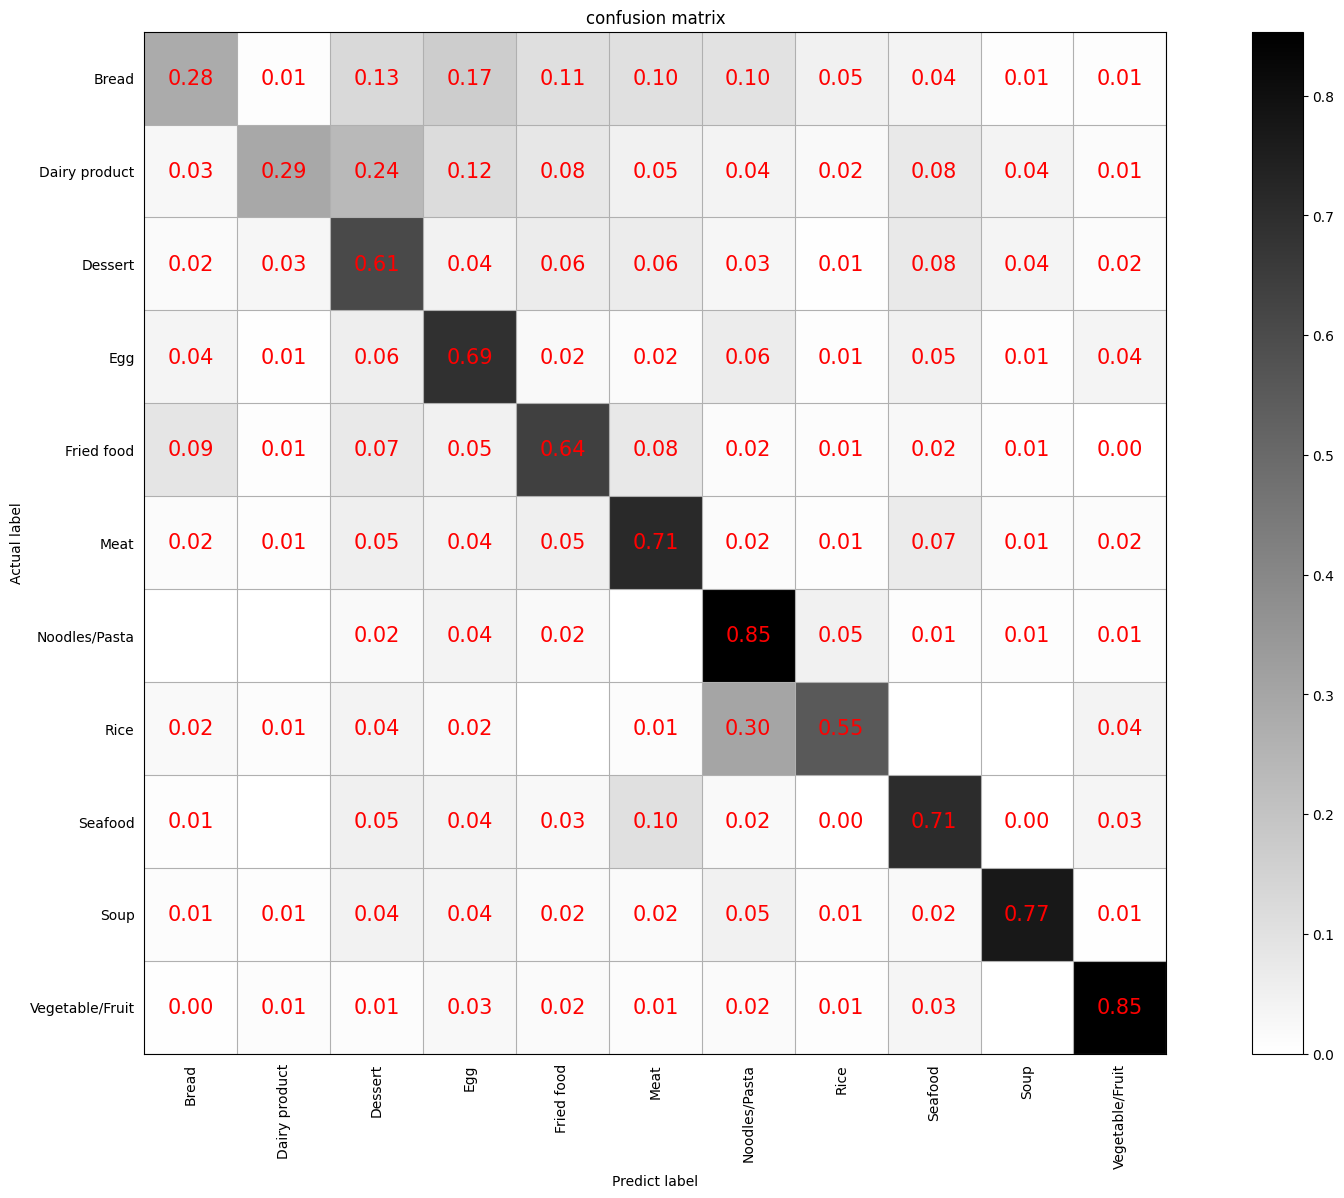

In [48]:
# plot confusion matrix
def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(22, 14), dpi=100)
    np.set_printoptions(precision=2)

    # confusion matrix 中每一格的機率
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savename, format='png')
    plt.show()
plot_confusion_matrix(cm_normalized, 'confusion_matrix.png', title='confusion matrix')

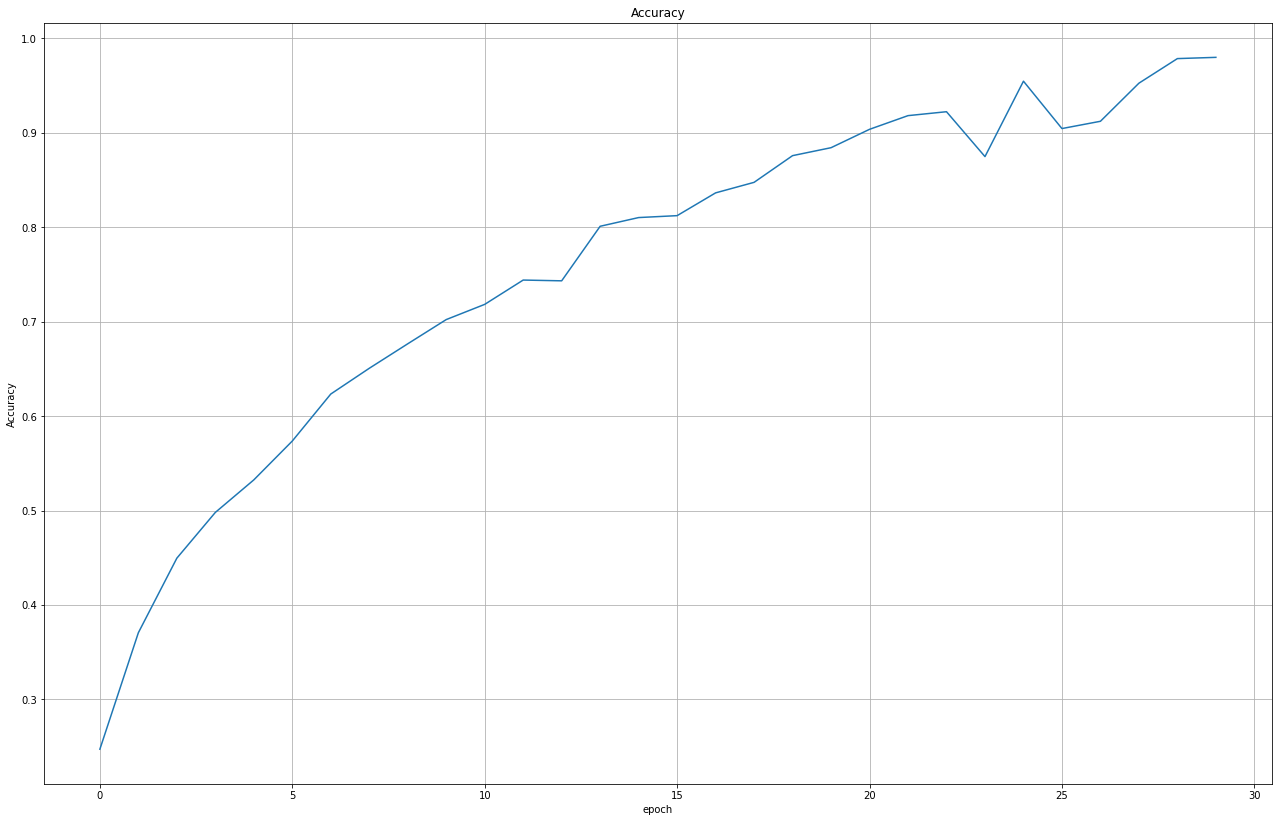

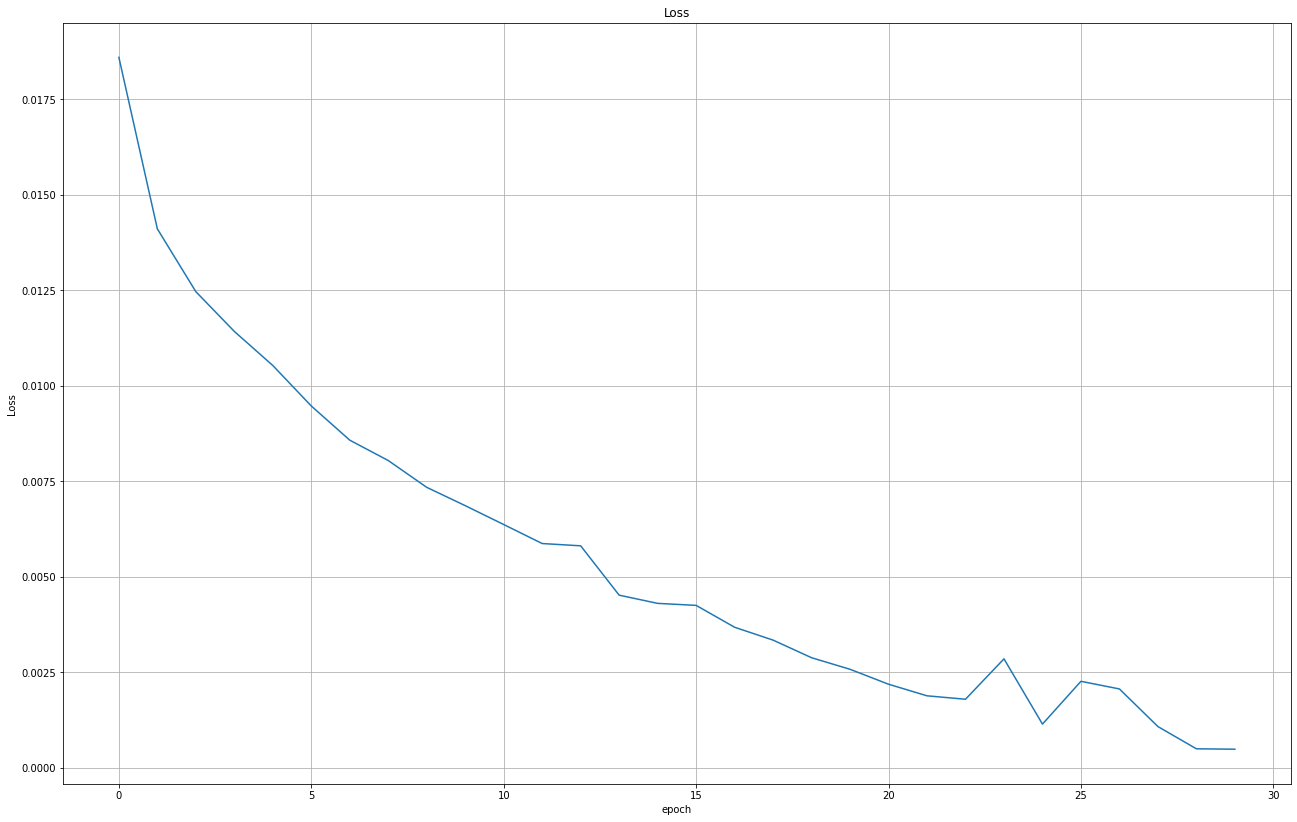

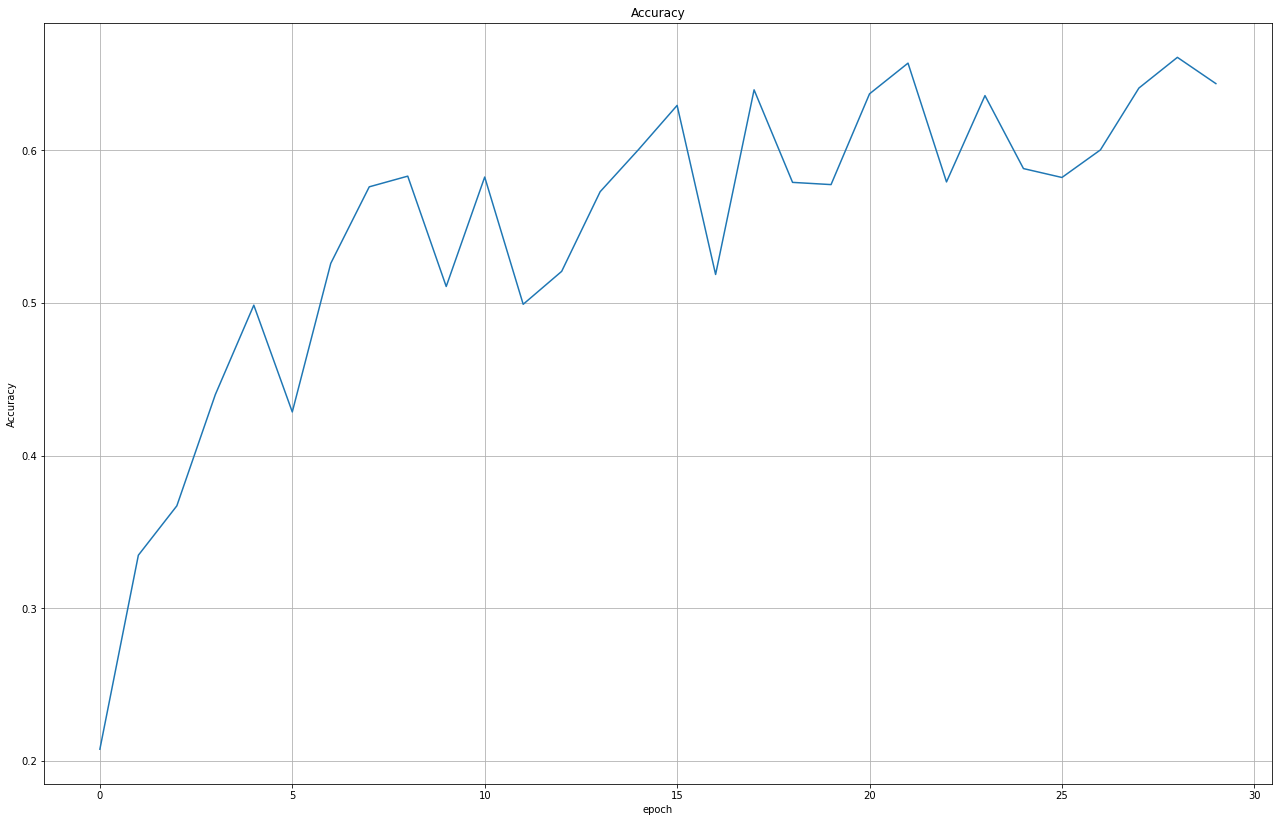

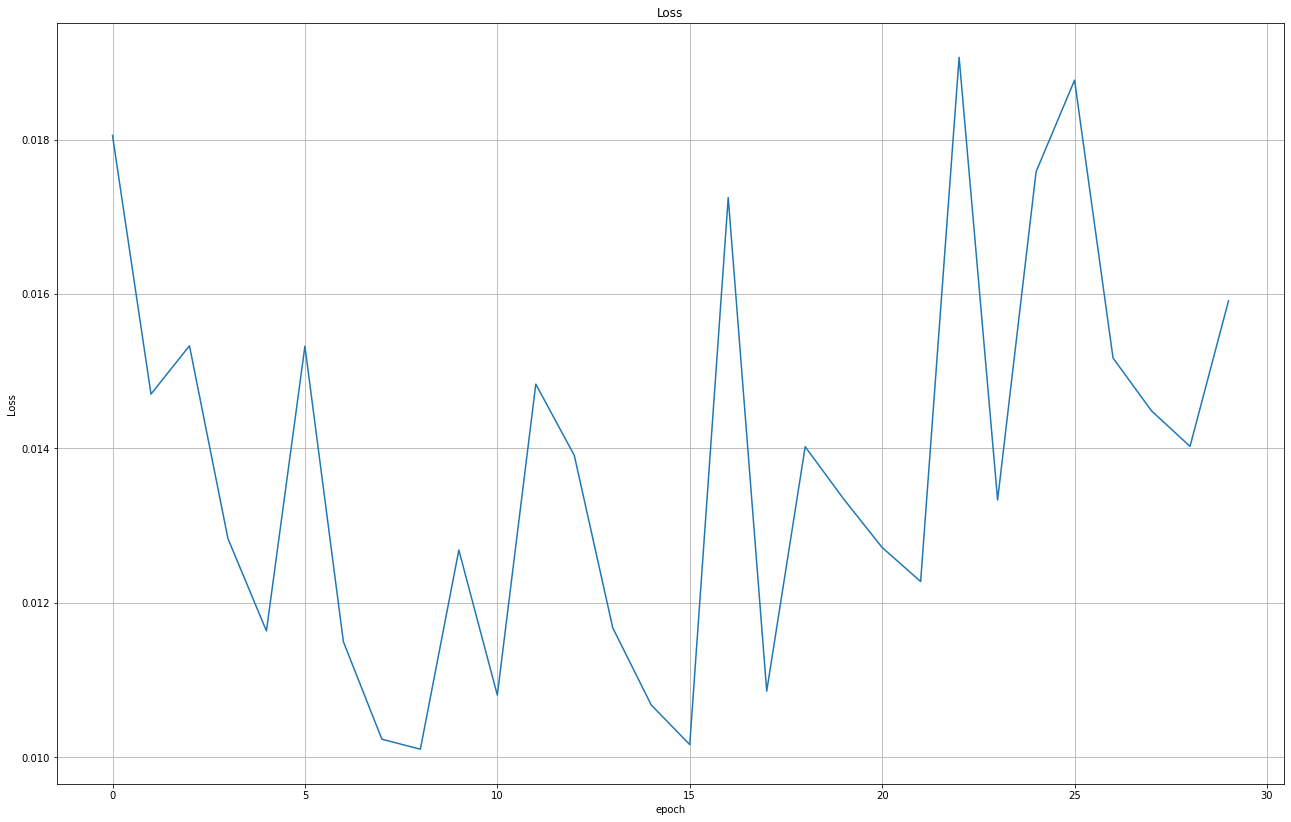

In [49]:
def plot_fig(input_list, typename ,savename, title):
    plt.figure(figsize=(22, 14))
    
    x = range(len(input_list))
    
    plt.title(title)
    plt.plot(x, input_list)
    plt.xlabel('epoch')
    plt.ylabel(typename)
    plt.grid(True)
    plt.savefig(savename, format='png')
    plt.show()
    
plot_fig(train_acc_list, 'Accuracy', 'train_accuracy.png', title='Accuracy')    
plot_fig(train_loss_list, 'Loss', 'train_loss.png', title='Loss')    
plot_fig(val_acc_list, 'Accuracy', 'val_accuracy.png', title='Accuracy')    
plot_fig(val_loss_list, 'Loss', 'val_loss.png', title='Loss')    

得到好的參數後，我們使用 training set 和 validation set 共同訓練（資料量變多，模型效果較好）

In [50]:
train_val_x = np.concatenate((train_x, val_x), axis=0) # 合併train & val set
train_val_y = np.concatenate((train_y, val_y), axis=0)
train_val_set = ImgDataset(train_val_x, train_val_y, train_transform)
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True)

In [51]:
model_best = Classifier().cuda()
loss = nn.CrossEntropyLoss() # 因為是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) # optimizer 使用 Adam
num_epoch = 30
# num_epoch = 15
train_acc_list = []
train_loss_list = []

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for i, data in enumerate(train_val_loader):
        optimizer.zero_grad()
        train_pred = model_best(data[0].cuda())
        batch_loss = loss(train_pred, data[1].cuda())
        batch_loss.backward()
        optimizer.step()

        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))

[001/030] 32.10 sec(s) Train Acc: 0.267900 Loss: 0.017926
[002/030] 32.04 sec(s) Train Acc: 0.408995 Loss: 0.013182
[003/030] 32.06 sec(s) Train Acc: 0.490298 Loss: 0.011501
[004/030] 32.11 sec(s) Train Acc: 0.554603 Loss: 0.010044
[005/030] 32.07 sec(s) Train Acc: 0.600030 Loss: 0.009022
[006/030] 32.12 sec(s) Train Acc: 0.624323 Loss: 0.008380
[007/030] 32.10 sec(s) Train Acc: 0.668998 Loss: 0.007567
[008/030] 32.06 sec(s) Train Acc: 0.690208 Loss: 0.006995
[009/030] 32.12 sec(s) Train Acc: 0.718487 Loss: 0.006372
[010/030] 32.08 sec(s) Train Acc: 0.741727 Loss: 0.005805
[011/030] 32.03 sec(s) Train Acc: 0.759702 Loss: 0.005422
[012/030] 32.06 sec(s) Train Acc: 0.784070 Loss: 0.004958
[013/030] 32.10 sec(s) Train Acc: 0.805881 Loss: 0.004378
[014/030] 32.07 sec(s) Train Acc: 0.824158 Loss: 0.003908
[015/030] 32.09 sec(s) Train Acc: 0.843412 Loss: 0.003547
[016/030] 32.12 sec(s) Train Acc: 0.853415 Loss: 0.003213
[017/030] 32.12 sec(s) Train Acc: 0.877858 Loss: 0.002658
[018/030] 32.0

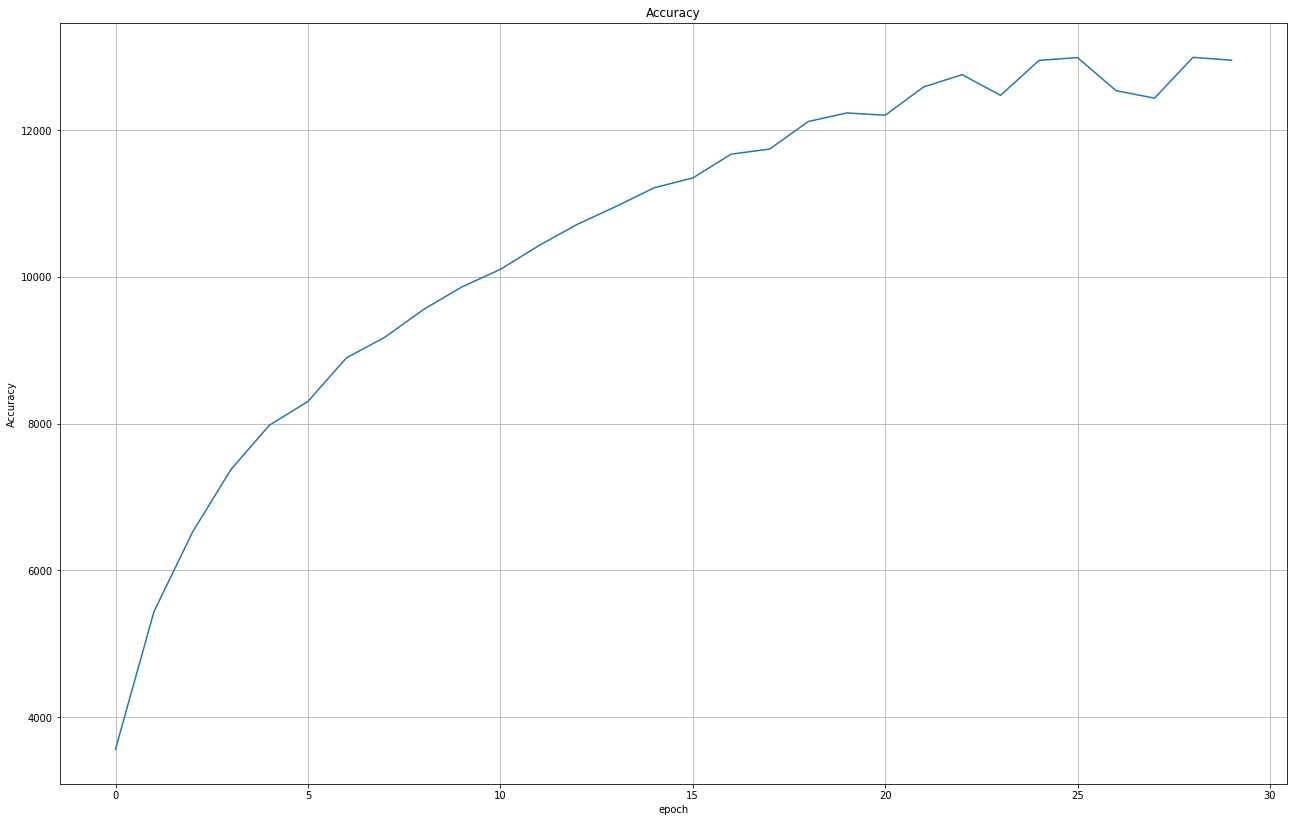

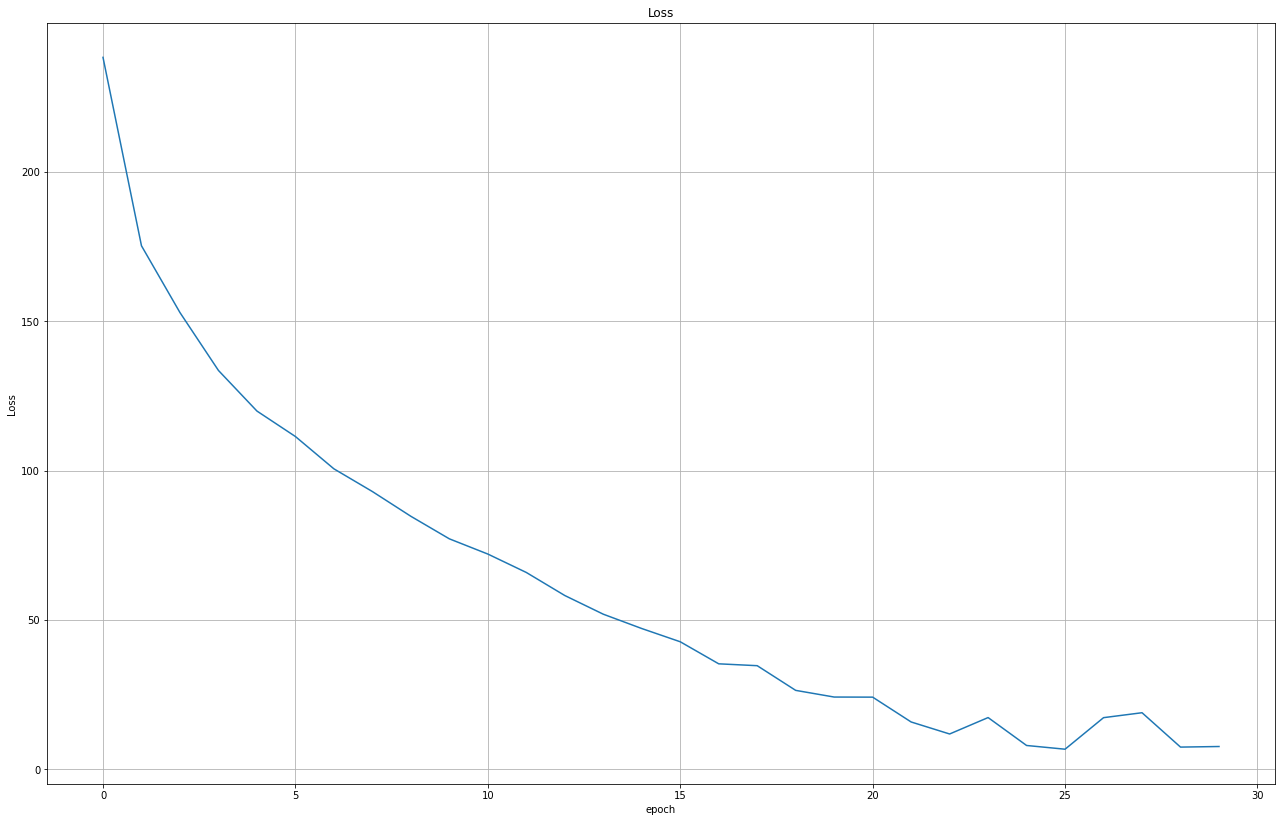

In [52]:
plot_fig(train_acc_list, 'Accuracy', 'train_accuracy.png', title='Accuracy')    
plot_fig(train_loss_list, 'Loss', 'train_loss.png', title='Loss')

# Testing
利用剛剛 train 好的 model 進行 prediction

In [53]:
test_set = ImgDataset(test_x, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [54]:
# # 僅用train set的模型
# model.eval()
# prediction = []
# with torch.no_grad():
#     for i, data in enumerate(test_loader):
#         test_pred = model_best(data.cuda())
#         test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
#         for y in test_label:
#             prediction.append(y)

# train & val set訓練出的模型
model_best.eval()
prediction = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model_best(data.cuda())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

In [55]:
# 將結果寫入 csv 檔
with open("predict.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))